# Multi-Agentic Workflow with LangGraph

## TRUSTCALL VISIBILITY

In [1]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [2]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [3]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Dd."), 
                AIMessage(content="Nice to meet you, Dd."), 
                HumanMessage(content="This morning I had a nice bike ride in San Antonio, Texas.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [4]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_vZATECBEKRB3RarHL6PldIrb)
 Call ID: call_vZATECBEKRB3RarHL6PldIrb
  Args:
    content: User had a nice bike ride in San Antonio, Texas this morning.


In [5]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='User had a nice bike ride in San Antonio, Texas this morning.'


In [6]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_vZATECBEKRB3RarHL6PldIrb'}


In [7]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, what did you do after?"), 
                        HumanMessage(content="I went to El Guacamole and ate some carne asada mini tacos."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about getting a job soon!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'User had a nice bike ride in San Antonio, Texas this morning.'})]

In [8]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [9]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_4RRpVw8OOZOtbesQCvoqQgBu', 'json_doc_id': '0'}
{'id': 'call_b0G1uQkFBa0uv94ziHcQwAbn'}


In [10]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_4RRpVw8OOZOtbesQCvoqQgBu)
 Call ID: call_4RRpVw8OOZOtbesQCvoqQgBu
  Args:
    content: User had a nice bike ride in San Antonio, Texas this morning. After the ride, they went to El Guacamole and ate some carne asada mini tacos.
  Memory (call_b0G1uQkFBa0uv94ziHcQwAbn)
 Call ID: call_b0G1uQkFBa0uv94ziHcQwAbn
  Args:
    content: User is thinking about getting a job soon.


In [11]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='User had a nice bike ride in San Antonio, Texas this morning. After the ride, they went to El Guacamole and ate some carne asada mini tacos.'
content='User is thinking about getting a job soon.'


In [12]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add a new memory entry about the user eating carne asada mini tacos at El Guacamole after their bike ride.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'User had a nice bike ride in San Antonio, Texas this morning. After the ride, they went to El Guacamole and ate some carne asada mini tacos.'}]},
   'id': 'call_4RRpVw8OOZOtbesQCvoqQgBu',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'User is thinking about getting a job soon.'},
   'id': 'call_b0G1uQkFBa0uv94ziHcQwAbn',
   'type': 'tool_call'}]]

In [13]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Add a new memory entry about the user eating carne asada mini tacos at El Guacamole after their bike ride.
Added content: User had a nice bike ride in San Antonio, Texas this morning. After the ride, they went to El Guacamole and ate some carne asada mini tacos.

New Memory created:
Content: {'content': 'User is thinking about getting a job soon.'}


## REACT AGENT

In [14]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

## GRAPH DEFINITION

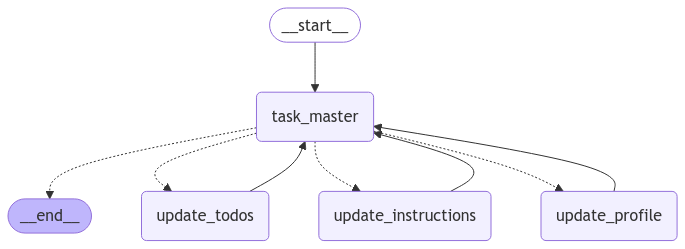

In [15]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    mode: Literal["anywhere", "errand", "home", "online", "phone"] = Field(
        description="How the task can be completed.",
        default="anywhere"
    )
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    location: Optional[str] = Field(
        description="Where the task can be completed.",
        default=None
    )
    bizhours_flag: Optional[bool] = Field(
        description="Whether the task needs to be completed during business hours during the day or not.",
        default=False
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_master(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=True).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_master)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_master")
builder.add_conditional_edges("task_master", route_message)
builder.add_edge("update_todos", "task_master")
builder.add_edge("update_profile", "task_master")
builder.add_edge("update_instructions", "task_master")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Dd"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Dd. I live in SAT with my wife Genevieve. I have a 1 year old puppy named Hungry and a 15 year old dog named Despereaux.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Dd. I live in SAT with my wife Genevieve. I have a 1 year old puppy named Hungry and a 15 year old dog named Despereaux.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_NeNBixfRAABXokOmnkCXpzHv)
 Call ID: call_NeNBixfRAABXokOmnkCXpzHv
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! If there's anything else you'd like to share or need help with, just let me know.


In [17]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book an appointment for Despereaux's comprehensive exam with the vet.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book an appointment for Despereaux's comprehensive exam with the vet.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_PYvWhY5UKhPIxD44JNnVIqGx)
 Call ID: call_PYvWhY5UKhPIxD44JNnVIqGx
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': "Book an appointment for Despereaux's comprehensive exam with the vet.", 'mode': 'phone', 'time_to_complete': 15, 'bizhours_flag': True, 'solutions': ["Call the vet's office to schedule an appointment", "Check the vet's online portal for appointment booking"], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task to book an appointment for Despereaux's comprehensive exam with the vet to your ToDo list. If you need any help 

In [18]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JESEmHj3qeiYxZ14CSL1Wi1b)
 Call ID: call_JESEmHj3qeiYxZ14CSL1Wi1b
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include specific local businesses or vendors when creating or updating your ToDo items. If there's anything else you need, just let me know!


In [19]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating a ToDo item, ask the user for a deadline and mode if none are specified.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating a ToDo item, ask the user for a deadline and mode if none are specified.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Q1kS1uNH1IojSuRt7QG6RNkh)
 Call ID: call_Q1kS1uNH1IojSuRt7QG6RNkh
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Understood! I'll ask for a deadline and mode if they're not specified when creating or updating a ToDo item. If you have any other preferences or need assistance, feel free to let me know!


In [20]:
# Check for updated instructions
user_id = "Dd"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': "Here are the updated instructions based on your feedback:\n\n<updated_instructions>\n- When creating or updating ToDo items, include specific local businesses or vendors relevant to the task.\n- If no deadline is specified, ask the user for a deadline.\n- If no mode is specified, ask the user for a preferred mode of completion (e.g., phone, online, in-person).\n</updated_instructions>\n\nIf there's anything else you'd like to adjust, just let me know!"}


In [21]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to bring the giant Jenga blocks from the yard to the garage.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to bring the giant Jenga blocks from the yard to the garage.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Ou4C5F9Jlx7NinJOzt0cgHyo)
 Call ID: call_Ou4C5F9Jlx7NinJOzt0cgHyo
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Bring the giant Jenga blocks from the yard to the garage.', 'mode': 'errand', 'time_to_complete': 10, 'solutions': ['Move the blocks manually', 'Use a cart or dolly to transport the blocks'], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task to bring the giant Jenga blocks from the yard to the garage to your ToDo list. If you need any help or have more tasks to add, just let me know!


In [22]:
# User input to validate ToDo item
input_messages = [HumanMessage(content="What's the mode for this task?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What's the mode for this task?
================================== Ai Message ==================================

The mode for the task "Bring the giant Jenga blocks from the yard to the garage" is set as an "errand." If you need to change it or have any other questions, feel free to ask!


In [23]:
# User input to validate ToDo item
input_messages = [HumanMessage(content="Change it to home.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Change it to home.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_K0DLmxUF350pRZJ9QgKkyyWf)
 Call ID: call_K0DLmxUF350pRZJ9QgKkyyWf
  Args:
    update_type: todo
================================= Tool Message =================================

Document d5bcde6a-61eb-4e95-82f8-fae91287f2ea updated:
Plan: Change the mode of the task from 'errand' to 'home'.
Added content: home
================================== Ai Message ==================================

I've updated the mode for the task to "home." If there's anything else you need, just let me know!


In [24]:
# User input to validate ToDo items
input_messages = [HumanMessage(content="List all my todo items with the mode home.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

List all my todo items with the mode home.
================================== Ai Message ==================================

Here are your ToDo items with the mode set to "home":

1. **Task:** Bring the giant Jenga blocks from the yard to the garage.
   - **Time to Complete:** 10 minutes
   - **Solutions:** Move the blocks manually, Use a cart or dolly to transport the blocks
   - **Status:** Not started

If you need more details or have other tasks to manage, feel free to ask!


In [25]:
# User input to validate ToDo item
input_messages = [HumanMessage(content="What about phone?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What about phone?
================================== Ai Message ==================================

Here is your ToDo item with the mode set to "phone":

1. **Task:** Book an appointment for Despereaux's comprehensive exam with the vet.
   - **Time to Complete:** 15 minutes
   - **Solutions:** Call the vet's office to schedule an appointment, Check the vet's online portal for appointment booking
   - **Status:** Not started

Let me know if there's anything else you need!


In [26]:
# User input to validate ToDo item
input_messages = [HumanMessage(content="What about errand?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What about errand?
================================== Ai Message ==================================

It looks like there are no ToDo items with the mode set to "errand" at the moment. If you have any tasks to add or need further assistance, just let me know!


In [27]:
# Namespace for the memory to save
user_id = "Dd"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

{'name': 'Dd', 'location': 'SAT', 'job': None, 'connections': ['Genevieve', 'Hungry', 'Despereaux'], 'interests': []}


In [28]:
# User input to validate profile item
input_messages = [HumanMessage(content="I love eating tacos!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I love eating tacos!
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_sls43wzNiX9RveYvbNpFUEM3)
 Call ID: call_sls43wzNiX9RveYvbNpFUEM3
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Tacos are delicious! If you ever need recommendations for taco places or anything else, feel free to ask!


In [29]:
# Namespace for the memory to save
user_id = "Dd"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

{'name': 'Dd', 'location': 'SAT', 'job': None, 'connections': ['Genevieve', 'Hungry', 'Despereaux'], 'interests': ['eating tacos']}


In [30]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the jenga blocks, I need it done before this Sunday.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the jenga blocks, I need it done before this Sunday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_EYRJnOAtRKJXRvSEcWjov00h)
 Call ID: call_EYRJnOAtRKJXRvSEcWjov00h
  Args:
    update_type: todo
================================= Tool Message =================================

Document d5bcde6a-61eb-4e95-82f8-fae91287f2ea updated:
Plan: Add a deadline to the task to ensure it is completed before Sunday.
Added content: 2025-01-19T23:59:59
================================== Ai Message ==================================

I've updated the task to include a deadline for completion before this Sunday. If there's anything else you need, just let me know!


## NEW THREAD

In [31]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Dd"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

You have two tasks on your ToDo list:

1. **Book an appointment for Despereaux's comprehensive exam with the vet.**
   - Estimated time to complete: 15 minutes
   - Mode: Phone
   - Solutions: Call the vet's office to schedule an appointment, or check the vet's online portal for appointment booking.

2. **Bring the giant Jenga blocks from the yard to the garage.**
   - Estimated time to complete: 10 minutes
   - Mode: Home
   - Solutions: Move the blocks manually, or use a cart or dolly to transport the blocks.

You can complete both tasks within 30 minutes. Would you like to start with one of these tasks?


In [32]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Task 1 cannot be done today because it's past business hours.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Task 1 cannot be done today because it's past business hours.
================================== Ai Message ==================================

Got it! Since it's past business hours, you can focus on the second task:

- **Bring the giant Jenga blocks from the yard to the garage.**
  - Estimated time to complete: 10 minutes

You can get this task done now. Let me know if you need any help!


In [33]:
# Chat with the chatbot
input_messages = [HumanMessage(content="When listing todo items, do not include tasks that can only be done during busines hours if it's past 4 PM.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When listing todo items, do not include tasks that can only be done during busines hours if it's past 4 PM.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_xU2LfJPX69y0htDoFNPoRtw4)
 Call ID: call_xU2LfJPX69y0htDoFNPoRtw4
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've updated the instructions to exclude tasks that can only be done during business hours if it's past 4 PM when listing ToDo items. If there's anything else you'd like to adjust, just let me know!


In [34]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I have 15 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 15 minutes, what tasks can I get done?
================================== Ai Message ==================================

You can work on the following task:

- **Bring the giant Jenga blocks from the yard to the garage.**
  - Estimated time to complete: 10 minutes

This task can be completed within your available 15 minutes. Let me know if you need any assistance!


In [35]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Can you remind me about our past conversations?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you remind me about our past conversations?
================================== Ai Message ==================================

Here's a summary of our past interactions:

1. **User Profile:**
   - Name: Dd
   - Location: SAT
   - Connections: Genevieve, Hungry, Despereaux
   - Interests: Eating tacos

2. **ToDo List:**
   - Book an appointment for Despereaux's comprehensive exam with the vet (cannot be done after business hours).
   - Bring the giant Jenga blocks from the yard to the garage.

3. **Instructions for ToDo List:**
   - Include specific local businesses or vendors relevant to the task.
   - Ask for a deadline if none is specified.
   - Ask for a preferred mode of completion if none is specified.
   - Do not include tasks that can only be done during business hours if it is past 4 PM.

If there's anything specific you'd like to revisit or update, feel free to let me know!
